In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.stats import expon
from scipy.stats import norm
from scipy import stats

from collections import Counter

from math import radians, cos, sin, asin, sqrt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

In [2]:
# df = pd.read_csv('最终干净的数据.csv')
path = 'C:\\Users\\ASUS\\Desktop\\IOM魔改2\\IOM209\\最终干净的数据改.csv'
try:
    # 将 low_memory 设置为 False
    df = pd.read_csv(path, low_memory=False)
    print("文件读取成功")
except FileNotFoundError:
    print("文件未找到，请检查文件路径。")
except Exception as e:
    print(f"发生其他错误: {e}")

文件读取成功


In [3]:
selected_features = [
    'tradeTime', 'followers', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
    'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition', 
    'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 
    'subway', 'district', 'communityAverage', 'distance', 'Age', 
    'floorType', 'floorHeight', 'room_count', 'room_ratio','north_south','Investment in residential real estate development in Beijing'
]

In [4]:
X = df[selected_features]      # 特征列
y = df['price_log']            # 回归目标：对数价格

In [5]:
#数据集划分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [9]:
#开始随机森林

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化模型
rf_model = RandomForestRegressor(
    n_estimators=100,        # 树的数量
    max_depth=10,            # 控制深度防止过拟合
    random_state=42,         
    n_jobs=-1              
)

# 模型训练
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [7]:
# 预测 log(price)
y_pred = rf_model.predict(X_test)

# 评估 log 结果
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
r2_log = r2_score(y_test, y_pred)

print("Random Forest - Log Space:")
print(f"R²: {r2_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")

Random Forest - Log Space:
R²: 0.8920
RMSE (log): 0.1459


In [8]:
# 还原原始 price 单位
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

# 评估原始价格单位
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print("\n Random Forest - Original Price:")
print(f"RMSE (RMB/m²): {rmse_original:.2f}")


 Random Forest - Original Price:
RMSE (RMB/m²): 6191.03


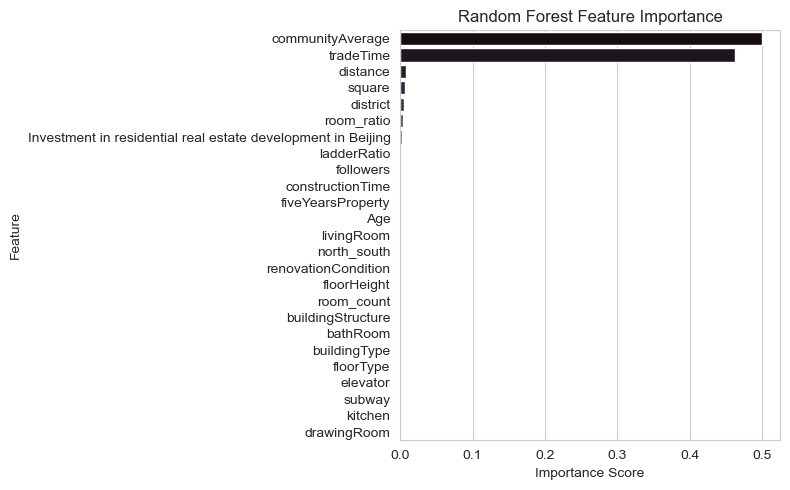

In [9]:
# 构建 DataFrame
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# 可视化
plt.figure(figsize=(8, 5))
sns.barplot(data=rf_importance, x='importance', y='feature', palette='mako')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [10]:
#害怕过拟合
# 训练集表现
y_train_pred = rf_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"Training Set R²: {r2_train:.4f}")

Training Set R²: 0.9011


In [11]:
#交叉验证
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Cross Validation R² Average Value: {cv_scores.mean():.4f}")

Cross Validation R² Average Value: 0.7379


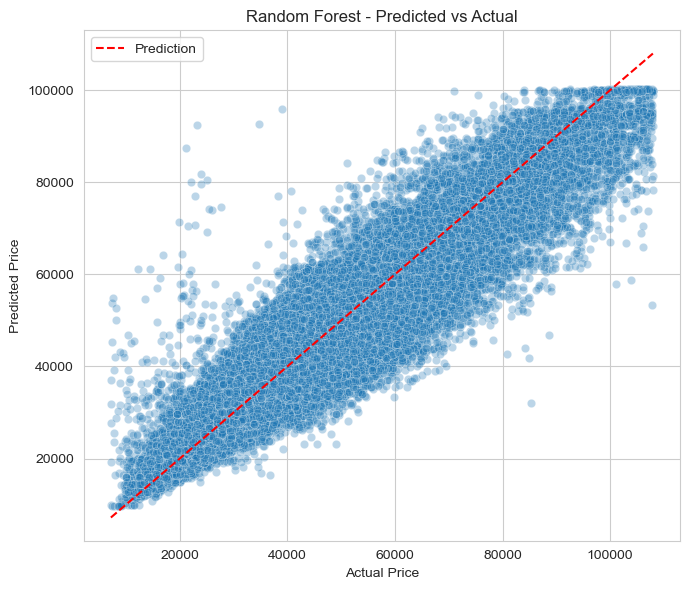

In [12]:
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--',label='Prediction')  

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest - Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
#GridSearchCV调整关键超参数

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],   # 每棵树再切分前所需的最小样本数
    'min_samples_leaf': [1, 2, 4],     # 叶子节点最小样本
    'max_features': ['sqrt', 'log2']   # 特征选择方式
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 输出最佳参数和分数
rf_grid.fit(X_train, y_train)
print("Best Parameters:", rf_grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [14]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_grid.best_estimator_, X, y, cv=5, scoring='r2')
print(f"Cross Validation R² Average Value: {cv_scores.mean():.4f}")

KeyboardInterrupt: 

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# 自定义RMSE评分指标
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

# 进行R²交叉验证
r2_cv_scores = cross_val_score(rf_grid.best_estimator_, X, y, cv=5, scoring='r2')
# 进行RMSE交叉验证
rmse_cv_scores = cross_val_score(rf_grid.best_estimator_, X, y, cv=5, scoring=rmse_scorer)

# 输出交叉验证的R²平均值
print(f"Cross Validation R² Average Value: {r2_cv_scores.mean():.4f}")
# 输出交叉验证的RMSE平均值
print(f"Cross Validation RMSE Average Value: {rmse_cv_scores.mean():.4f}")

Cross Validation R² Average Value: 0.7337
Cross Validation RMSE Average Value: 0.1871


In [32]:
# Fitting 5 folds for each of 108 candidates, totalling 540 fits
# Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [33]:
best_rf = rf_grid.best_estimator_

# 预测与评估
y_pred = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred)
rmse_rf_log = np.sqrt(mean_squared_error(y_test, y_pred))

# 回归还原
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)
rmse_rf_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print(f"Best RF R²: {r2_rf:.4f}")
print(f"Best RF RMSE (log): {rmse_rf_log:.4f}")
print(f"Best RF RMSE (original): {rmse_rf_orig:.2f} RMB/m²")

Best RF R²: 0.9090
Best RF RMSE (log): 0.1340
Best RF RMSE (original): 5768.77 RMB/m²


In [34]:
#接下来我们尝试特征选择和降维进一步优化模型表现

In [35]:
#步骤一：查看特征重要性排列

In [36]:
# 特征重要性排序（以 Random Forest 为例，事实上任何模型都可以降维）
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# 显示前20个重要特征
top_features = rf_importance['feature'].head(20).tolist()
print(top_features)

['communityAverage', 'tradeTime', 'Investment in residential real estate development in Beijing', 'distance', 'followers', 'district', 'renovationCondition', 'Age', 'square', 'room_ratio', 'constructionTime', 'subway', 'north_south', 'ladderRatio', 'buildingStructure', 'floorHeight', 'room_count', 'floorType', 'elevator', 'buildingType']


In [37]:
#步骤二：构建新的子集训练模型（Top N 特征）
# 只保留重要特征
X_top = X[top_features]

# 重新划分训练集
X_train_top, X_test_top, y_train, y_test = train_test_split(
    X_top, y, test_size=0.3, random_state=42
)

# 用原来的 best_rf 或新模型训练
best_rf.fit(X_train_top, y_train)
y_pred_top = best_rf.predict(X_test_top)

# 评估表现
from sklearn.metrics import mean_squared_error, r2_score
r2_top = r2_score(y_test, y_pred_top)
rmse_top = np.sqrt(mean_squared_error(y_test, y_pred_top))

print(f"Top Feature R²: {r2_top:.4f}")
print(f"Top Feature RMSE (log): {rmse_top:.4f}")

Top Feature R²: 0.9081
Top Feature RMSE (log): 0.1347


In [38]:
#步骤三：使用 RFE（递归特征消除）自动筛选特征
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# 用 RFE 选择最优特征（这里选择 15 个）
rfe_selector = RFE(estimator=RandomForestRegressor(n_estimators=100), n_features_to_select=15)
rfe_selector = rfe_selector.fit(X, y)

# 提取保留的特征名
rfe_features = X.columns[rfe_selector.support_].tolist()
print("RFE Selected Features:", rfe_features)

# 使用 RFE 特征训练
X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X[rfe_features], y, test_size=0.3, random_state=42)
best_rf.fit(X_train_rfe, y_train)
y_pred_rfe = best_rf.predict(X_test_rfe)

# 评估
r2_rfe = r2_score(y_test, y_pred_rfe)
rmse_rfe = np.sqrt(mean_squared_error(y_test, y_pred_rfe))
print(f"RFE Feature R²: {r2_rfe:.4f}")
print(f"RFE Feature RMSE (log): {rmse_rfe:.4f}")

RFE Selected Features: ['tradeTime', 'followers', 'square', 'constructionTime', 'renovationCondition', 'ladderRatio', 'fiveYearsProperty', 'district', 'communityAverage', 'distance', 'Age', 'floorType', 'floorHeight', 'room_count', 'room_ratio']
RFE Feature R²: 0.9061
RFE Feature RMSE (log): 0.1361


In [39]:
#步骤四：PCA 主成分分析
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 降维到 10 个主成分
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 划分训练集
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# 拟合模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)
y_pred_pca = rf_model.predict(X_test_pca)

# 评估
r2_pca = r2_score(y_test, y_pred_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
print(f"PCA R²: {r2_pca:.4f}")
print(f"PCA RMSE (log): {rmse_pca:.4f}")

PCA R²: 0.7579
PCA RMSE (log): 0.2185


In [ ]:
#结果：Top-N特征选择，精度不降反升，模型更简洁
#RFE递归特征消除精度基本一致（稍高），是自动特征选择中比较稳健的方法
#PCA主成分降维明显降低了模型表现，不建议用于当前任务；同时会压缩线性信息，丢失原始特征的可解释性